In [5]:
!nvidia-smi

Thu Dec  8 13:51:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P5    21W / 240W |   4753MiB /  8192MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
#force to use CPU
# torch.cuda.is_available = lambda : False
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pathlib
import time
import os

temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

import utils
display = utils.notebook_init()

import urllib.request
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2

import glob

import torchvision.transforms as transforms

import torch.nn.functional as F
import imutils as im
from utils.dataloaders import LoadImages
from utils.general import check_img_size
from utils.augmentations import classify_transforms

car_model = torch.hub.load('C:\Project\yolov5', 'custom', path='C:\Project\yolov5\my_weight\car_model_600.pt', source='local')

license_model = torch.hub.load('C:\Project\yolov5', 'custom', path='C:\Project\yolov5\my_weight\license_object_detection_500_real.pt', source='local')

model = torch.hub.load('C:\Project\yolov5', 'custom', path='C:\Project\yolov5\my_weight\letter_object_nano_all_real_final.pt', source='local')

classification_model = torch.hub.load('C:\Project\yolov5', 'custom', path='C:\Project\yolov5\my_weight\letter_class_real_100epoch_big.pt', source='local')

alphabet_dict = {
    "0E01": "ก",
    "0E02": "ข",
    "0E04": "ค",
    "0E06": "ฆ",
    "0E07": "ง",
    "0E08": "จ",
    "0E09": "ฉ",
    "0E0A": "ช",
    "0E0C": "ฌ",
    "0E0D": "ญ",
    "0E0E": "ฎ",
    "0E10": "ฐ",
    "0E12": "ฒ",
    "0E13": "ณ",
    "0E14": "ด",
    "0E15": "ต",
    "0E16": "ถ",
    "0E17": "ท",
    "0E18": "ธ",
    "0E19": "น",
    "0E1A": "บ",
    "0E1B": "ป",
    "0E1C": "ผ",
    "0E1E": "พ",
    "0E1F": "ฟ",
    "0E20": "ภ",
    "0E21": "ม",
    "0E22": "ย",
    "0E23": "ร",
    "0E25": "ล",
    "0E27": "ว",
    "0E28": "ศ",
    "0E29": "ษ",
    "0E2A": "ส",
    "0E2B": "ห",
    "0E2C": "ฬ",
    "0E2D": "อ",
    "0E2E": "ฮ",
    "n0": "0",
    "n1":"1",
    "n2":"2",
    "n3":"3",
    "n4":"4",
    "n5":"5",
    "n6":"6",
    "n7":"7",
    "n8":"8",
    "n9":"9"
}
number_list = ["n1","n2","n3","n4","n5","n6","n7","n8","n9","n0"]

YOLOv5  2022-12-7 Python-3.9.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)


Setup complete  (16 CPUs, 15.8 GB RAM, 390.2/465.1 GB disk)


YOLOv5  2022-12-7 Python-3.9.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
YOLOv5  2022-12-7 Python-3.9.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
YOLOv5  2022-12-7 Python-3.9.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
YOLOv5  2022-12-7 Python-3.9.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)

Fusing layers... 
Model summary: 117 layers, 4228176 parameters, 0 gradients, 10.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


In [2]:
%matplotlib inline
#lenght 640 for yolov5, padding the width will auto apply to the image
path = "./input_image/input_from_camera/2022_11_08_15_18_05_978__04__1__กง6123__1__246181667895483208.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = car_model(img)
dfResults = results.pandas().xyxy[0]
# plt.imshow(np.squeeze(results.render()))
# plt.show()

In [3]:
if len(dfResults) >=1:
    image = img
    image_arr = np.array(image)
    #if there are more than one car on the image (change letter_index to select which car do you want)
    letter_index=0
    x1=int(results.xyxy[0][letter_index][0])
    x2=int(results.xyxy[0][letter_index][2])
    y1=int(results.xyxy[0][letter_index][1])
    y2=int(results.xyxy[0][letter_index][3])
    image_arr2 = image_arr[y1:y2, x1:x2]
    save_img2 = Image.fromarray(image_arr2)
    save_img2.save("crop_car.jpg")

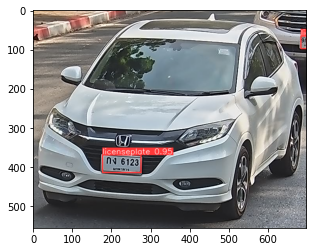

In [4]:
results = license_model(image_arr2)
dfResults = results.pandas().xyxy[0]
plt.imshow(np.squeeze(results.render()))
plt.show()

In [5]:
image = Image.fromarray(image_arr2)
#convert to grayscale
image = image.convert('L')
image_arr = np.array(image)
#if there are more than license plate on the image (change letter_index to select which license plate do you want)
letter_index=0
#automatic select license plate that width size more than height
while len(results.xyxy[0]) > letter_index:
    x1=int(results.xyxy[0][letter_index][0])
    x2=int(results.xyxy[0][letter_index][2])
    y1=int(results.xyxy[0][letter_index][1])
    y2=int(results.xyxy[0][letter_index][3])
    if (x2-x1) > (y2-y1):
        image_arr2 = image_arr[y1:y2, x1:x2]
        break
    letter_index+=1

save_img2 = Image.fromarray(image_arr2)
save_img2.save("crop_img_original.jpg")


#resize license plate to be bigger
def image_resize(image, width = None, height = None, inter = cv2.INTER_CUBIC):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

#resize
save_img = image_resize(image_arr2, height = 200)

#reduce noise
save_img = cv2.fastNlMeansDenoising(save_img, None, 20, 7, 21)

#shapening
kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
save_img = cv2.filter2D(save_img, -1, kernel)

cv2.imwrite('crop_img.jpg',save_img)

True

         xmin        ymin        xmax        ymax  confidence  class      name
0   43.049232   23.804541  102.907059  110.496223    0.949455      0   letters
1  311.978851   43.878975  363.149353  129.196625    0.949122      0   letters
2  269.604736   41.251923  304.667938  125.561089    0.941868      0   letters
3  116.372322  133.956512  310.905701  189.328857    0.939859      1  province
4  207.273697   35.505466  259.779602  119.829933    0.936935      0   letters
5  366.913483   45.868412  413.452667  131.996338    0.932185      0   letters
6  111.293144   29.987854  164.526260  115.249176    0.927277      0   letters
##########################################################################################
tensor([[ 43.04923,  23.80454, 102.90706, 110.49622,   0.94946,   0.00000],
        [311.97885,  43.87897, 363.14935, 129.19662,   0.94912,   0.00000],
        [269.60474,  41.25192, 304.66794, 125.56109,   0.94187,   0.00000],
        [116.37232, 133.95651, 310.90570, 189.328

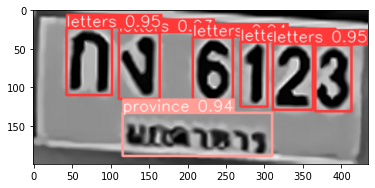

In [6]:
img = "crop_img.jpg"
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#send license plate image to the model
results = model(img)

dfResults = results.pandas().xyxy[0]
print(dfResults)
print("###"*30)
print(results.xyxy[0])

plt.imshow(np.squeeze(results.render()))
plt.show()

In [8]:
#create an array and sort the x coordination of the alphabets to display from left to right
count_letter=len(results.xyxy[0])
if(torch.cuda.is_available()):
    xmin_sort=torch.tensor([]).to('cuda')
else:
    xmin_sort=torch.tensor([]).to('cpu')
for i in range(count_letter):
    #convert from dim0 to dim1
    if(torch.cuda.is_available()):
        xmin=torch.tensor([results.xyxy[0][i][0]]).to('cuda')
    else:
        xmin=torch.tensor([results.xyxy[0][i][0]]).to('cpu')
    #append each xmin into xmin_sort list
    xmin_sort=torch.cat((xmin_sort,xmin),0)
xmin_sorted, _ = torch.sort(xmin_sort)
print(xmin_sorted)

tensor([ 43.04923, 111.29314, 116.37232, 207.27370, 269.60474, 311.97885, 366.91348], device='cuda:0')


In [9]:
if len(results.pandas().xyxy[0]) > 0:
    image = Image.open('crop_img.jpg')
    image_arr = np.array(image)
    license_string=""
    license_string_list=[]
    string_count=0
    letter_index=0
    #it is like run 2 for loop
    #loop แรกคือ i=0 เพื่อเลือก xmin ที่น้อยที่สุดจาก sorted list ออกมา
    while letter_index<count_letter:
      my_index=0
      while my_index < count_letter:
        #loop 2 คือค้นหาใน results ว่า ข้อมูลของ xmin อันนี้คืออะไร
        if xmin_sorted[letter_index] == results.xyxy[0][my_index][0]:
          #check if it is letter class (there are two class from the letter object detection model which are letter and province but we choose only letter class)
          if results.xyxy[0][my_index][5] < 1:
            x1=int(results.xyxy[0][my_index][0])
            x2=int(results.xyxy[0][my_index][2])
            y1=int(results.xyxy[0][my_index][1])
            y2=int(results.xyxy[0][my_index][3])
            image_arr2 = image_arr[y1:y2, x1:x2]

            #resize to 224x224 before put into the model
            image_arr2 = cv2.resize(image_arr2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            save_img = Image.fromarray(image_arr2)
            save_img.save("crop_alphabet"+str(string_count)+".jpg")

            ### Clasification Model ###
            img_path = "crop_alphabet"+str(string_count)+".jpg"
            stride = classification_model.stride
            vid_stride=1
            imgsz=(224, 224)
            imgsz = check_img_size(imgsz, s=stride)
            dataset = LoadImages(img_path, img_size=imgsz, transforms=classify_transforms(imgsz[0]), vid_stride=vid_stride)
            for _, im, _, _, s in dataset:
              img = im
            #add batch to image array
            img = img.unsqueeze(0)
            #add image array to tensor store in Nvidia vram
            if(torch.cuda.is_available()):
              img = torch.Tensor(img).to('cuda')
            else:
              img = torch.Tensor(img).to('cpu')

            img = img.half() if classification_model.fp16 else img.float()
            if len(img.shape) == 3:
              img = img[None]
            #input to model
            names = classification_model.names
            classification_results = classification_model(img)
            pred = F.softmax(classification_results, dim=1)
            for i, prob in enumerate(pred):
              top3i = prob.argsort(0, descending=True)[:2].tolist()
            mark=0
            for i in top3i:
              if mark==0:
                mark=1
                if(prob[i]>=0.1):
                  license_string_list.append(names[i])
              print("predict: %s prob: %.2f" %(alphabet_dict[names[i]],prob[i]))
            print()
            letter_index=letter_index+1
            my_index=count_letter
            string_count+=1
          else:
            letter_index=letter_index+1
        my_index=my_index+1
    for i in license_string_list:
      license_string=license_string+alphabet_dict[i]
    print(license_string_list)
    print(license_string)

predict: ก prob: 0.89
predict: ณ prob: 0.00

predict: ง prob: 0.90
predict: ฆ prob: 0.00

predict: 6 prob: 0.82
predict: 8 prob: 0.01

predict: 1 prob: 0.74
predict: ก prob: 0.02

predict: 2 prob: 0.90
predict: 9 prob: 0.00

predict: 3 prob: 0.86
predict: ญ prob: 0.00

['0E01', '0E07', 'n6', 'n1', 'n2', 'n3']
กง6123


In [14]:
# #province classification but we not use this in our project yet
# if len(results.pandas().xyxy[0]) > 0:
#     image = Image.open('/home/xai/yolov5/crop_img.jpg')
#     #gray scale
#     # image = image.convert('L')
#     image_arr = np.array(image)
#     #image_arr[y1:y2, x1:x2]
#     my_index=0
#     while my_index < count_letter:
#       if results.xyxy[0][my_index][5] > 0:
#         letter_index=my_index
#         my_index=count_letter
#         x1=int(results.xyxy[0][letter_index][0])
#         x2=int(results.xyxy[0][letter_index][2])
#         y1=int(results.xyxy[0][letter_index][1])
#         y2=int(results.xyxy[0][letter_index][3])
#         image_arr2 = image_arr[y1:y2, x1:x2]

#         #resize to 224x224 before put into the model
#         image_arr2 = cv2.resize(image_arr2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
#         save_img = Image.fromarray(image_arr2)
#         save_img.save("crop_province.jpg")

#         #convert binary
#         image1 = cv2.imread("crop_province.jpg") 
#         img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
#         ret, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         cv2.imwrite("crop_province.jpg",thresh)

#         ### Clasification Model ###
#         img_path = "crop_province.jpg"
#         stride = classification_model.stride
#         vid_stride=1
#         imgsz=(224, 224)
#         imgsz = check_img_size(imgsz, s=stride)
#         dataset = LoadImages(img_path, img_size=imgsz, transforms=classify_transforms(imgsz[0]), vid_stride=vid_stride)
#         for _, im, _, _, s in dataset:
#           img = im
#         #add batch to image array
#         img = img.unsqueeze(0)
#         #add image array to tensor store in Nvidia vram
#         if(torch.cuda.is_available()):
#           img = torch.Tensor(img).to('cuda')
#         else:
#           img = torch.Tensor(img).to('cpu')

#         img = img.half() if classification_model.fp16 else img.float()
#         if len(img.shape) == 3:
#           img = img[None]
#         #input to model
#         names = province_classification_model.names
#         province_classification_results = province_classification_model(img)
#         pred = F.softmax(province_classification_results, dim=1)
#         for i, prob in enumerate(pred):
#           top2i = prob.argsort(0, descending=True)[:2].tolist()
#         print()
#         for i in top2i:
#           print("predict: %s " %(names[i]))
#           print("prob: %.2f" %(prob[i]))
#           print("."*20)
#       else:
#         my_index+=1

Image Upscaling

In [15]:
# import cv2
# from cv2 import dnn_superres

# # Create an SR object
# sr = dnn_superres.DnnSuperResImpl_create()

# # Read image
# image = cv2.imread('/home/xai/yolov5/crop_img.jpg')

# # Read the desired model
# path = "/home/xai/yolov5/EDSR_x4.pb"
# sr.readModel(path)

# # Set the desired model and scale to get correct pre- and post-processing
# sr.setModel("edsr", 3)

# # Upscale the image
# result = sr.upsample(image)

# # Save the image
# cv2.imwrite("/home/xai/yolov5/crop_img.jpg", result)